In [1]:
import pickle
import numpy as np
import geopandas as gpd
from pyproj import Geod
from shapely.geometry import Point, LineString, MultiLineString
from shapely.ops import nearest_points
from concurrent.futures import ThreadPoolExecutor 
from scipy.interpolate import NearestNDInterpolator
import matplotlib.pyplot as plt

In [2]:
dataset = gpd.read_file('../data/lines.shp')
dataset = MultiLineString(dataset['geometry'].values)

In [2]:
lat = np.arange(-899,900) / 10
lon = np.arange(-1800,1800) / 10
points = np.array(np.meshgrid(lon, lat)).T.reshape(-1,2)
points = np.append(points, [[0, -90], [0, 90]], axis=0)
points = np.array([Point(lon, lat) for (lon, lat) in points])
points.size

6476402

In [4]:
geod = Geod(ellps="WGS84")
def get_distance(args):
    point, line = args
    return geod.geometry_length(LineString(nearest_points(point, line)))
with ThreadPoolExecutor(max_workers=20) as executor:
    shortest_distance = executor.map(get_distance, zip(points, [dataset]*points.size))
shortest_distance = np.array(list(shortest_distance))

In [3]:
#with open('shortest_distance.list', "wb") as file:
#   pickle.dump(shortest_distance, file)

with open('shortest_distance.list', "rb") as file:
   shortest_distance = pickle.load(file)

In [4]:
shortest_distance = shortest_distance / 1000

### Тепловая карта по shortest_distance

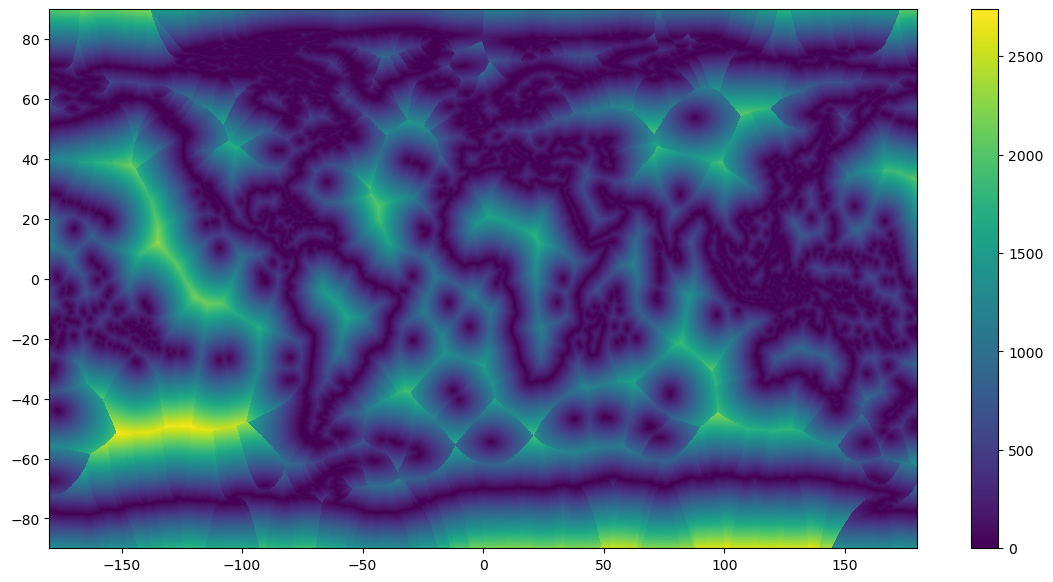

In [5]:
X, Y = np.meshgrid(lon, lat)

plt.rcParams["figure.figsize"] = (14,7)
plt.pcolormesh(X, Y, shortest_distance[:-2].reshape(-1,lat.size).T, cmap='viridis')
plt.colorbar()
plt.show()

In [6]:
lat = np.arange(-899,900) / 10
lon = np.arange(-1800,1800) / 10
points = np.array(np.meshgrid(lon, lat)).T.reshape(-1,2)
points = np.append(points, [[0, -90], [0, 90]], axis=0)

def lonlat2xyz(coordinates_lon_lat):
    return np.array([[
        np.cos(np.deg2rad(lat)) * np.cos(np.deg2rad(lon)),
        np.cos(np.deg2rad(lat)) * np.sin(np.deg2rad(lon)),
        np.sin(np.deg2rad(lat))
    ] for (lon, lat) in coordinates_lon_lat])

points = lonlat2xyz(points)

interp = NearestNDInterpolator(points, shortest_distance)


In [7]:
with open('NearestNDInterpolator', "wb") as file:
    pickle.dump(interp, file)

### Тепловая карта по spline

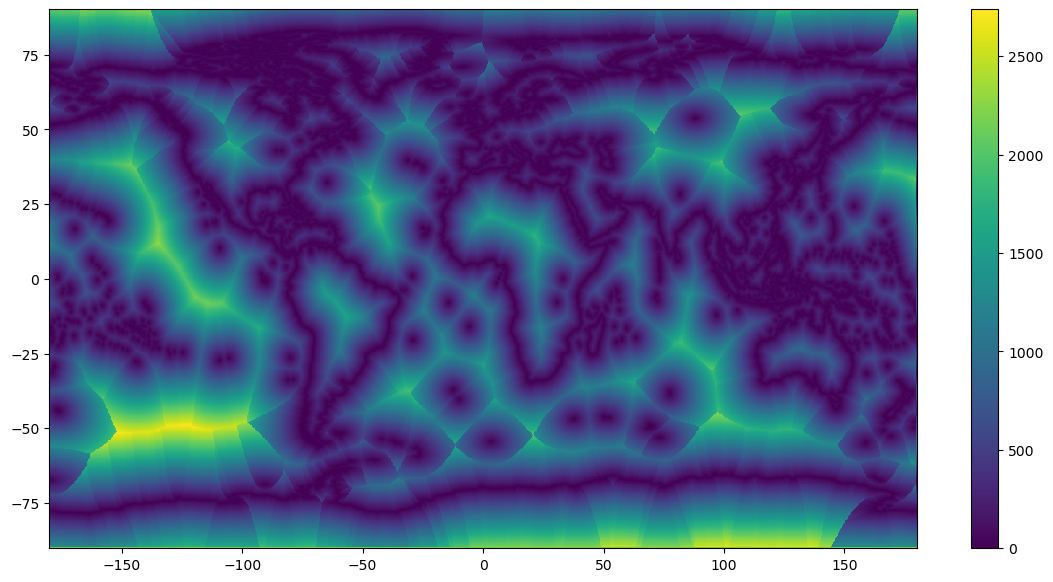

In [8]:
number_points = 600

lat = np.linspace(-90, 90, num=number_points)
lon = np.linspace(-180, 180, num=2*number_points)
points = np.array(np.meshgrid(lon, lat)).T.reshape(-1,2)
points = lonlat2xyz(points)
value = interp(points).reshape(-1,lat.size).T

X, Y = np.meshgrid(lon, lat)
plt.rcParams["figure.figsize"] = (14,7)
plt.pcolormesh(X, Y, value, shading='auto')
#plt.legend()
plt.colorbar()
#plt.axis("equal")
plt.show()